In [4]:
print("Hello I am Manish Pandey")

Hello I am Manish Pandey


Housing  Prices Analysis & Prediction

Required Libraries

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import joblib 
import os


In [6]:
#Plot settings
%matplotlib inline
sns.set_style('whitegrid') 

In [7]:
#Paths
data_path = "housing_prices.csv"
output_dir = 'output'
os.makedirs('output',exist_ok=True)

Load and Explore the data

In [8]:
#load dataset
df=pd.read_csv(data_path)
print(f" Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
df.head()


 Loaded dataset with 545 rows and 14 columns


,price,area,Location,bedrooms,bathrooms,stories,mainroad,guestroom,basement,hotwaterheating,airconditioning,parking,prefarea,furnishingstatus
0,13300000,7420,Kharghar,4,2,3,yes,no,no,no,yes,2,yes,furnished
1,12250000,8960,Kharghar,4,4,4,yes,no,no,no,yes,3,no,furnished
2,12250000,9960,Kharghar,3,2,2,yes,no,yes,no,no,2,yes,semi-furnished
3,12215000,7500,Kharghar,4,2,2,yes,no,yes,no,yes,3,yes,furnished
4,11410000,7420,Kharghar,4,1,2,yes,yes,yes,no,yes,2,no,furnished


In [9]:
#Basic Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 545 entries, 0 to 544
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   price             545 non-null    int64 
 1   area              545 non-null    int64 
 2   Location          545 non-null    object
 3   bedrooms          545 non-null    int64 
 4   bathrooms         545 non-null    int64 
 5   stories           545 non-null    int64 
 6   mainroad          545 non-null    object
 7   guestroom         545 non-null    object
 8   basement          545 non-null    object
 9   hotwaterheating   545 non-null    object
 10  airconditioning   545 non-null    object
 11  parking           545 non-null    int64 
 12  prefarea          545 non-null    object
 13  furnishingstatus  545 non-null    object
dtypes: int64(6), object(8)
memory usage: 59.7+ KB


In [10]:
#Describe
df.describe()

,price,area,bedrooms,bathrooms,stories,parking
count,5.450000e+02,545.000000,545.000000,545.000000,545.000000,545.000000
mean,4.766729e+06,5150.541284,2.965138,1.286239,1.805505,0.693578
std,1.870440e+06,2170.141023,0.738064,0.502470,0.867492,0.861586
min,1.750000e+06,1650.000000,1.000000,1.000000,1.000000,0.000000
25%,3.430000e+06,3600.000000,2.000000,1.000000,1.000000,0.000000
50%,4.340000e+06,4600.000000,3.000000,1.000000,2.000000,0.000000
75%,5.740000e+06,6360.000000,3.000000,2.000000,2.000000,1.000000
max,1.330000e+07,16200.000000,6.000000,4.000000,4.000000,3.000000


In [11]:
#Missing value counts
miss = df.isnull().sum().sort_values(ascending=False)
miss[miss > 0]

Series([], dtype: int64)

In [12]:
#Target is  'Price'
target_col = "price"
print('Using target column : ' ,target_col)

df[target_col].describe()

Using target column :  price


count    5.450000e+02
mean     4.766729e+06
std      1.870440e+06
min      1.750000e+06
25%      3.430000e+06
50%      4.340000e+06
75%      5.740000e+06
max      1.330000e+07
Name: price, dtype: float64

In [13]:
#Feature engineering : price per square foot
df['price_per_sqft'] = df['price'] / df['area'].replace(0,np.nan)

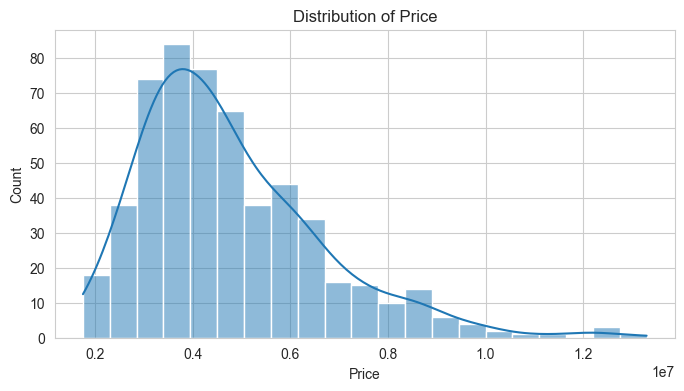

In [14]:
#Distribution of target
plt.figure(figsize=(8,4))
sns.histplot(df[target_col],kde=True)
plt.title("Distribution of Price")
plt.xlabel('Price')
plt.show()

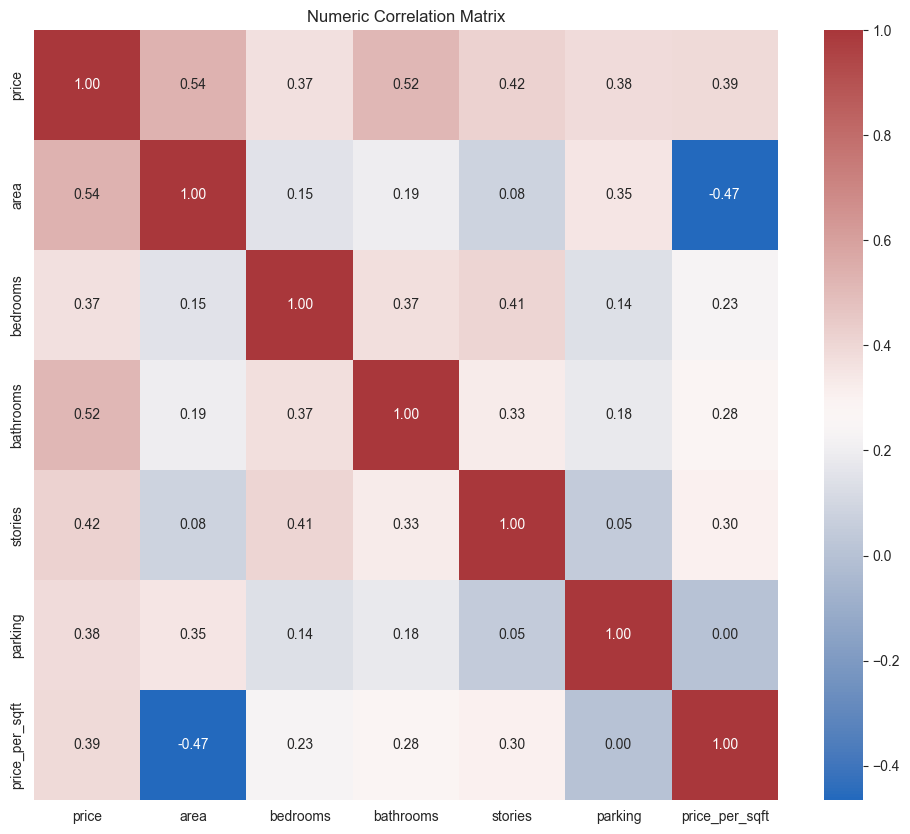

In [15]:
#Correlation heatmap of numeric features
num_df = df.select_dtypes(include=[np.number])
plt.figure(figsize=(12,10))
sns.heatmap(num_df.corr(),annot=True , fmt='.2f',cmap='vlag')
plt.title('Numeric Correlation Matrix')
plt.show()

In [16]:
#Outlier removal (remove rows outside 1st/99th percentile for price)
low ,high = df[target_col].quantile([0.01,0.99])
df_clean = df[(df[target_col] >=low) & (df[target_col] <= high)].copy()
print('After trimming extremes: ',df_clean.shape)

After trimming extremes:  (533, 15)


In [17]:
#Identity feature types
X = df_clean.drop(columns = [target_col,'price_per_sqft']) #exclude engineered feature
y = df_clean[target_col]

numeric_features = X.select_dtypes(include=[np.number]).columns.tolist()
cat_features = X.select_dtypes(include=['object','category','bool']).columns.tolist()


print('Numeric : ',numeric_features)
print("Categorical : ",cat_features)

Numeric :  ['area', 'bedrooms', 'bathrooms', 'stories', 'parking']
Categorical :  ['Location', 'mainroad', 'guestroom', 'basement', 'hotwaterheating', 'airconditioning', 'prefarea', 'furnishingstatus']


In [18]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler

In [19]:
#pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer',SimpleImputer(strategy='median')),
    ('scaler',StandardScaler())
])

cat_transformer = Pipeline(steps = [
    ('imputer',SimpleImputer(strategy='most_frequent')),
    ('onehot',OneHotEncoder(handle_unknown='ignore'))

])

preprocessor = ColumnTransformer(transformers=[
    ('num',numeric_transformer,numeric_features),
    ('cat',cat_transformer,cat_features)
])

In [20]:
from sklearn.model_selection import train_test_split

In [21]:
#train/test split
X_train, X_test ,y_train , y_test = train_test_split(X,y,random_state=42,test_size=0.2)
print(X_train.shape,X_test.shape)

(426, 13) (107, 13)


In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [23]:
#Models
models = {}

#Linear Regression
models['linreg'] = Pipeline(steps=[('preprocessor',preprocessor),
                                   ('regressor',LinearRegression())])

#Random Forest
models['rf'] = Pipeline(steps=[
    ('preprocessor',preprocessor),
    ('regressor',RandomForestRegressor(n_estimators=200,random_state=42,n_jobs=-1))
])

#Fit and Evaluate
results = {}
for name,m in models.items():
    print('Training',name)
    m.fit(X_train,y_train)
    preds= m.predict(X_test)

    #MAE
    mae = mean_absolute_error(y_test,preds)
    #RMSE (manually compute square root of MSE)
    mse = mean_squared_error(y_test,preds)
    rmse =np.sqrt(mse)
    #R2
    r2 = r2_score(y_test,preds)

    results[name] ={'mae': mae , 'rmse':rmse , 'r2': r2}
    print(f"{name} ->MAE: {mae:,.0f},\n RMSE : {rmse:,.0f},\n R2: {r2:.3f}")

results

Training linreg
linreg ->MAE: 632,166,
 RMSE : 878,346,
 R2: 0.793
Training rf
rf ->MAE: 619,306,
 RMSE : 884,802,
 R2: 0.790


{'linreg': {'mae': 632165.6186198487,
  'rmse': np.float64(878346.2657247457),
  'r2': 0.7928930771972508},
 'rf': {'mae': 619305.6028037383,
  'rmse': np.float64(884802.4352125),
  'r2': 0.7898372628756196}}

In [24]:
#Choose model with Highest R2
best_name = max(results.keys(), key=lambda k: results[k]['r2'])
best_model = models[best_name]
print('Best model :\n',best_name,results[best_name])

Best model :
 linreg {'mae': 632165.6186198487, 'rmse': np.float64(878346.2657247457), 'r2': 0.7928930771972508}


In [25]:
#Save the model
model_path = os.path.join(output_dir,'best_model.joblib')
joblib.dump(best_model,model_path)
print('Saved model to',model_path)

Saved model to output\best_model.joblib


Best Model is Linear; showing Coefficients


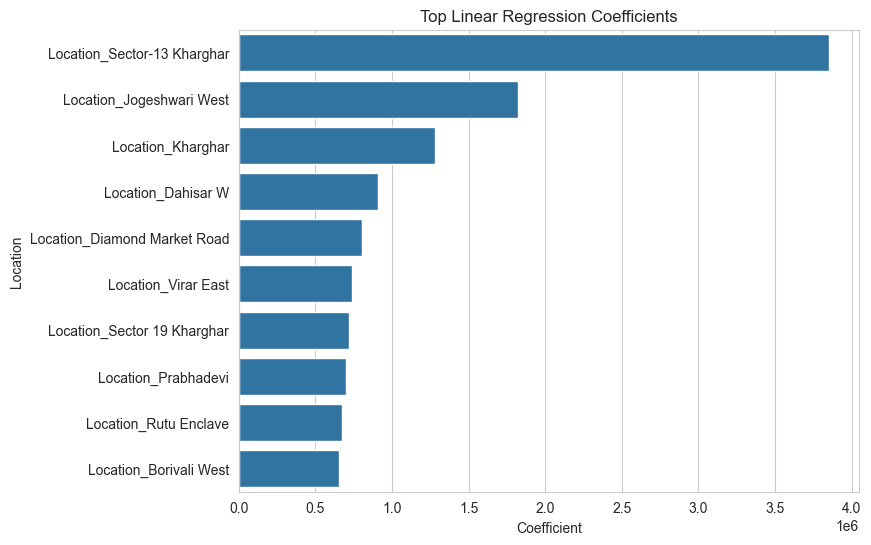

: 

In [ ]:
#Features importance
import numpy as np

if best_name == "rf":
    pre =best_model.named_steps['preprocessor']
    num_feats = numeric_features
    cat_cols = []
    if len(cat_features) > 0:
        ohe = pre.named_transformer_['cat'].named_steps['onehot']
        cat_cols = ohe.get_feature_name_out(cat_features).tolist()
    feature_names= np.array(num_feats +cat_cols)
    importances = best_model.named_steps['regressor'].feature_importances_
    fi = pd.Series(importances,index=feature_names).sort_values(ascending=False).head(10)
    plt.figure(figsize=(8,6))
    sns.barplot(x=fi.values , y=fi.index)
    plt.title('Top Feature Importances')
    plt.xlabel('Importance')
    plt.show()
else:
    print('Best Model is Linear; showing Coefficients')
    coefs = best_model.named_steps['regressor'].coef_
    pre = best_model.named_steps['preprocessor']
    num_feats = numeric_features
    cat_cols = []
    if len(cat_features) >0 :
        ohe = pre.named_transformers_['cat'].named_steps['onehot']
        cat_cols = ohe.get_feature_names_out(cat_features).tolist()
    feature_names = np.array(num_feats + cat_cols)
    coefs_series = pd.Series(coefs,index=feature_names).sort_values(ascending=False).head(10)
    plt.figure(figsize=(8,6))
    sns.barplot(x=coefs_series.values, y=coefs_series.index)
    plt.title('Top Linear Regression Coefficients')
    plt.xlabel('Coefficient')
    plt.ylabel('Location')
    plt.show()





In [ ]:
#Save prediction & evaluation report
preds = best_model.predict(X_test)
pd.DataFrame({'y_true': y_test, 'y_pred': preds}).to_csv(os.path.join(output_dir,'test_prediction.csv'),index=False)

report= {
    'results':results,
    'best_model' :best_name
}

In [ ]:
import json
with open(os.path.join(output_dir,'report.json'),'w') as f:
    json.dump(report,f,indent=2)

print('Outputs saved to' ,output_dir)